In [370]:
import numpy as np
import pandas as pd
import seaborn as sns
from pycaret.regression import *

In [371]:
train_df = pd.read_csv('train.tsv', sep='\t')
test_df = pd.read_csv('test.tsv', sep='\t')
sub=pd.read_csv('sample_submit.csv',header=None,names=['id','Label'])

In [372]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    199 non-null    int64  
 1   mpg           199 non-null    float64
 2   cylinders     199 non-null    int64  
 3   displacement  199 non-null    float64
 4   horsepower    199 non-null    object 
 5   weight        199 non-null    int64  
 6   acceleration  199 non-null    float64
 7   model year    199 non-null    int64  
 8   origin        199 non-null    int64  
 9   car name      199 non-null    object 
dtypes: float64(3), int64(5), object(2)
memory usage: 15.7+ KB


In [373]:
train_df.head(2)

,Unnamed: 0,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,0,39.4,4,85.0,70,2070,18.6,78,3,datsun b210 gx
1,3,18.0,6,171.0,97,2984,14.5,75,1,ford pinto


In [374]:
train_df.describe()

,Unnamed: 0,mpg,cylinders,displacement,weight,acceleration,model year,origin
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000
mean,200.170854,22.997990,5.527638,200.889447,3063.326633,15.599497,75.904523,1.587940
std,113.432759,7.693379,1.722692,110.158783,888.015282,2.885903,3.664728,0.817149
min,0.000000,9.000000,3.000000,70.000000,1613.000000,8.000000,70.000000,1.000000
25%,98.500000,16.000000,4.000000,106.000000,2300.000000,13.800000,73.000000,1.000000
50%,202.000000,22.000000,4.000000,151.000000,2865.000000,15.500000,76.000000,1.000000
75%,294.500000,28.000000,8.000000,302.000000,3800.500000,17.300000,79.000000,2.000000
max,396.000000,44.300000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


In [375]:
train_x = train_df
test_x = test_df

In [376]:
# 説明用に学習データとテストデータの元の状態を保存しておく
train_x_saved = train_x.copy()
test_x_saved = test_x.copy()

In [377]:
train_x['bland'] = train_x['car name'].apply(lambda x: x.split(' ')[0])
test_x['bland'] = test_x['car name'].apply(lambda x: x.split(' ')[0])

In [378]:
# -----------------------------------
# target encoding
# -----------------------------------
cat_cols = ['bland', 'origin']
print(cat_cols)

['bland', 'origin']


In [379]:
from sklearn.model_selection import KFold

# 変数をループしてtarget encoding
for c in cat_cols:
    # 学習データ全体で各カテゴリにおけるtargetの平均を計算
    data_tmp = pd.DataFrame({c: train_x[c], 'mpg': train_y})
    target_mean = data_tmp.groupby(c)['mpg'].mean()
    # テストデータのカテゴリを置換
    test_x[c] = test_x[c].map(target_mean)

    # 学習データの変換後の値を格納する配列を準備
    tmp = np.repeat(np.nan, train_x.shape[0])

    # 学習データを分割
    kf = KFold(n_splits=4, shuffle=True, random_state=72)
    for idx_1, idx_2 in kf.split(train_x):
        # out-of-foldで各カテゴリにおける目的変数の平均を計算
        target_mean = data_tmp.iloc[idx_1].groupby(c)['mpg'].mean()
        # 変換後の値を一時配列に格納
        tmp[idx_2] = train_x[c].iloc[idx_2].map(target_mean)

    # 変換後のデータで元の変数を置換
    train_x[c] = tmp

In [380]:
hp_impute =train_x[train_x['horsepower']!='?']
hp_impute['horsepower'] = hp_impute['horsepower'].astype(int)
hp_impute.groupby(['cylinders','bland'])['horsepower'].mean()

cylinders  bland    
3          27.700000    100.000000
           28.250000     97.000000
4          15.650000     84.000000
           16.366667     92.000000
           17.175000     90.000000
                           ...    
8          21.237500    155.000000
           21.466667    135.000000
           22.071429    175.000000
           22.320000    156.666667
           22.688889    142.500000
Name: horsepower, Length: 110, dtype: float64

In [381]:
train_x[train_x['horsepower']=='?']

,Unnamed: 0,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,bland
25,50,40.9,4,85.0,?,1835,17.3,80,27.304000,renault lecar deluxe,29.166667
80,166,34.5,4,100.0,?,2320,15.8,81,27.412000,renault 18i,33.950000
176,351,23.6,4,140.0,?,2905,14.3,80,19.609474,ford mustang cobra,19.436842


In [382]:
train_x[train_x['horsepower']=='?']
for idx in train_x.index.values:
    if idx == 25:
        train_x.at[idx,'horsepower'] = 76
    elif idx == 80:
        train_x.at[idx,'horsepower']= 76
    elif idx == 176:
        train_x.at[idx,'horsepower'] = 82

In [383]:
test_x[test_x['horsepower']=='?']

,Unnamed: 0,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,bland
50,101,4,151.0,?,3035,20.5,82,19.525806,amc concord dl,18.063636
85,164,6,200.0,?,2875,17.0,74,19.525806,ford maverick,19.471429
181,363,4,98.0,?,2046,19.0,71,19.525806,ford pinto,19.471429


In [384]:
for idx in test_x.index.values:
    if idx == 50:
        test_x.at[idx,'horsepower'] =90
    elif idx == 85:
        test_x.at[idx,'horsepower']=86
    elif idx == 181:
        test_x.at[idx,'horsepower'] = 86

In [385]:
train_x['horsepower']=train_x['horsepower'].astype(int)
test_x['horsepower']=test_x['horsepower'].astype(int)

In [386]:
train_x['disp/cyl'] = train_x['displacement'] / train_x['cylinders']
test_x['disp/cyl'] = test_x['displacement'] / test_x['cylinders']

In [387]:
train_x['hrspow/cyl'] = train_x['horsepower'] / train_x['cylinders']
test_x['hrspow/cyl'] = test_x['horsepower'] / test_x['cylinders']

In [388]:
train_x['accl/cyl'] = train_x['acceleration'] / train_x['cylinders']
test_x['accl/cyl'] = test_x['acceleration'] / test_x['cylinders']

In [389]:
columns = train_x.columns
print(columns)

Index(['Unnamed: 0', 'mpg', 'cylinders', 'displacement', 'horsepower',
       'weight', 'acceleration', 'model year', 'origin', 'car name', 'bland',
       'disp/cyl', 'hrspow/cyl', 'accl/cyl'],
      dtype='object')


array([[<AxesSubplot: xlabel='mpg', ylabel='mpg'>,
        <AxesSubplot: xlabel='cylinders', ylabel='mpg'>,
        <AxesSubplot: xlabel='displacement', ylabel='mpg'>,
        <AxesSubplot: xlabel='horsepower', ylabel='mpg'>,
        <AxesSubplot: xlabel='weight', ylabel='mpg'>,
        <AxesSubplot: xlabel='acceleration', ylabel='mpg'>,
        <AxesSubplot: xlabel='model year', ylabel='mpg'>,
        <AxesSubplot: xlabel='origin', ylabel='mpg'>,
        <AxesSubplot: xlabel='bland', ylabel='mpg'>],
       [<AxesSubplot: xlabel='mpg', ylabel='cylinders'>,
        <AxesSubplot: xlabel='cylinders', ylabel='cylinders'>,
        <AxesSubplot: xlabel='displacement', ylabel='cylinders'>,
        <AxesSubplot: xlabel='horsepower', ylabel='cylinders'>,
        <AxesSubplot: xlabel='weight', ylabel='cylinders'>,
        <AxesSubplot: xlabel='acceleration', ylabel='cylinders'>,
        <AxesSubplot: xlabel='model year', ylabel='cylinders'>,
        <AxesSubplot: xlabel='origin', ylabel='cylinde

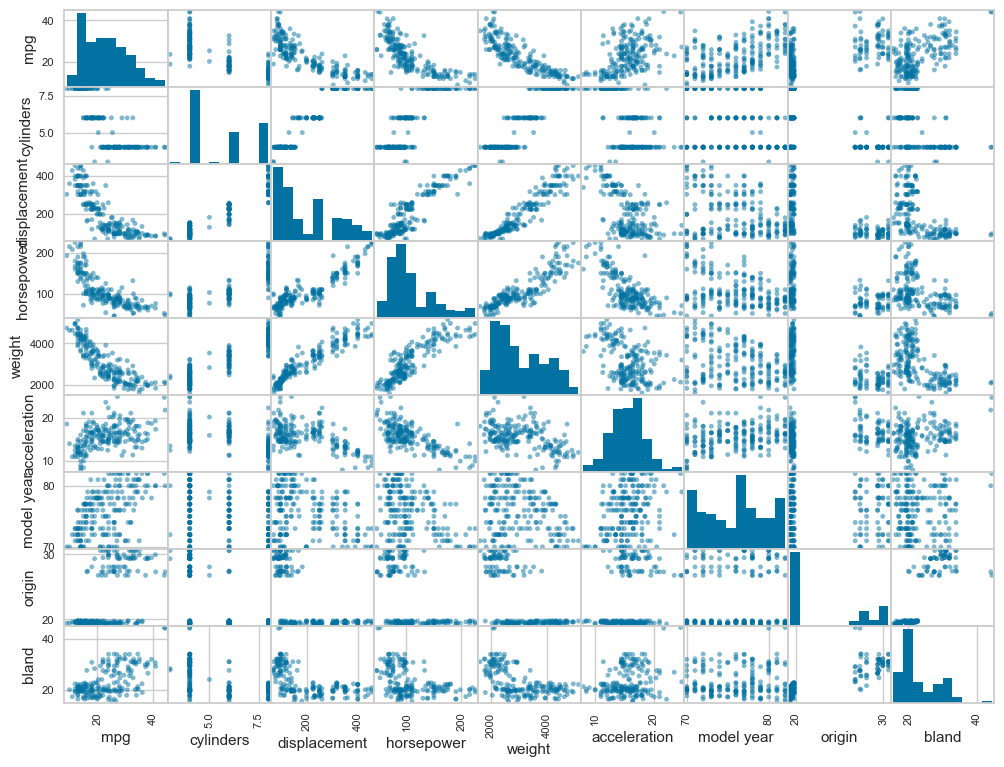

In [390]:
attributes = ['mpg', 'cylinders', 'displacement', 'horsepower',
       'weight', 'acceleration', 'model year', 'origin', 'bland']
scatter_matrix(train_x[attributes], figsize=(12, 9), alpha=0.5)

process

In [391]:
reg = setup(data = train_x,
            target = 'mpg',
            session_id=999,
            data_split_shuffle = True,
            categorical_features = ['bland'],
            fold_strategy = 'kfold',
            use_gpu = True,
            silent = True,
            fold=5,
            n_jobs = -1)

,Description,Value
0,session_id,999
1,Target,mpg
2,Original Data,"(199, 14)"
3,Missing Values,True
4,Numeric Features,9
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(139, 194)"


In [392]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,2.1245,7.4386,2.6970,0.8428,0.1157,0.0978,0.0080
br,Bayesian Ridge,2.1069,7.4540,2.6957,0.8419,0.1149,0.0966,0.0460
omp,Orthogonal Matching Pursuit,2.3053,8.3057,2.8504,0.8329,0.1199,0.1056,0.0100
catboost,CatBoost Regressor,2.1987,9.2866,2.9328,0.8064,0.1211,0.0986,1.1720
gbr,Gradient Boosting Regressor,2.2253,9.5052,2.9954,0.7970,0.1221,0.0993,0.0720
et,Extra Trees Regressor,2.3048,9.8521,3.0910,0.7895,0.1278,0.1028,0.3180
lr,Linear Regression,2.5288,10.0613,3.1550,0.7849,0.1447,0.1183,0.0220
rf,Random Forest Regressor,2.4281,10.9453,3.2242,0.7647,0.1317,0.1077,0.3380
ada,AdaBoost Regressor,2.4859,11.2932,3.3028,0.7617,0.1370,0.1131,0.0900
xgboost,Extreme Gradient Boosting,2.5049,10.9504,3.2451,0.7614,0.1356,0.1131,0.5500


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=999, solver='auto', tol=0.001)

In [393]:
top3 = compare_models(sort = 'MAE', n_select=3 
								,exclude =['lar','dummy','lr','xgboost','lasso'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,2.1069,7.4540,2.6957,0.8419,0.1149,0.0966,0.0380
ridge,Ridge Regression,2.1245,7.4386,2.6970,0.8428,0.1157,0.0978,0.0080
catboost,CatBoost Regressor,2.1987,9.2866,2.9328,0.8064,0.1211,0.0986,1.0960
gbr,Gradient Boosting Regressor,2.2253,9.5052,2.9954,0.7970,0.1221,0.0993,0.0700
et,Extra Trees Regressor,2.3048,9.8521,3.0910,0.7895,0.1278,0.1028,0.3220
omp,Orthogonal Matching Pursuit,2.3053,8.3057,2.8504,0.8329,0.1199,0.1056,0.0120
rf,Random Forest Regressor,2.4281,10.9453,3.2242,0.7647,0.1317,0.1077,0.3260
ada,AdaBoost Regressor,2.4859,11.2932,3.3028,0.7617,0.1370,0.1131,0.0880
knn,K Neighbors Regressor,2.8477,14.0288,3.7317,0.7144,0.1502,0.1270,0.0160
lightgbm,Light Gradient Boosting Machine,2.9424,15.7964,3.8998,0.6671,0.1599,0.1313,0.2240


In [394]:
blender = blend_models(top3)
final = finalize_model(blender)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.2128,10.1239,3.1818,0.8463,0.1248,0.0973
1,1.3345,2.7970,1.6724,0.9567,0.0807,0.0670
2,2.4338,10.4724,3.2361,0.7645,0.1173,0.0990
3,2.1156,7.7904,2.7911,0.7972,0.1165,0.0934
4,1.9341,5.7735,2.4028,0.8550,0.1134,0.1004
Mean,2.0062,7.3914,2.6569,0.8440,0.1106,0.0914
Std,0.3725,2.8581,0.5767,0.0654,0.0154,0.0124


In [395]:
result = predict_model(final, data = test_x)
sub['Label'] = result['Label']
sub['Label'] = sub['Label'].astype(int)

In [396]:
sub.to_csv('sub.csv',header=False,index=False)

In [397]:
sub.head()

,id,Label
0,1,13
1,2,23
2,4,23
3,5,35
4,6,35


In [398]:
sub.Label.max() ,sub.Label.min()

(38, 11)

In [399]:
train_x.mpg.max()

44.3